In [1]:
import scipy
import numpy as np
from fitters import *
from tools import *
from plots import *
from projectors import *
set_seaborn()
sns.set_theme()
%load_ext autoreload
%autoreload 2


In [2]:
def get_data(Ydataset, factor, Xdataset='PHOTO'):
    resX, stim = read_lmc(Xdataset)
    resY, stim = read_lmc(Ydataset)
    X = preprocess(resX, factor=factor, method='mean')
    Y = preprocess(resY, factor=factor, method='mean')

    return X, Y


30


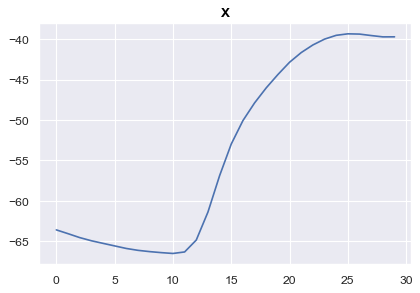

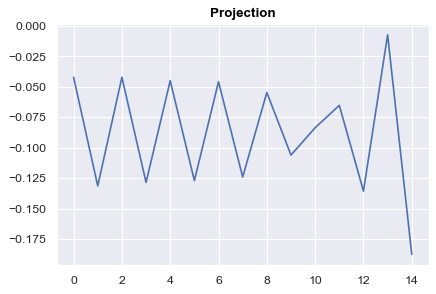

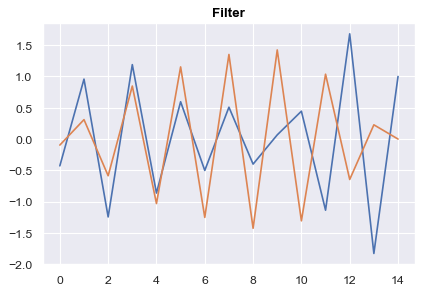

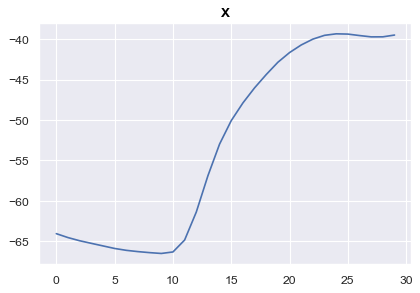

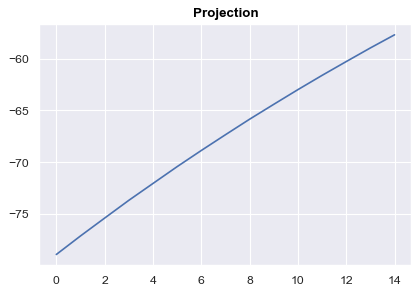

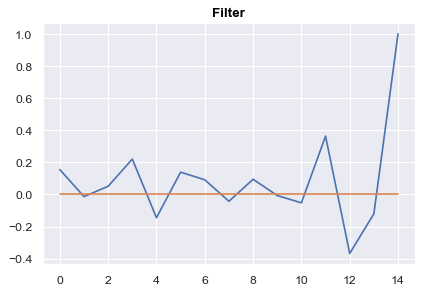

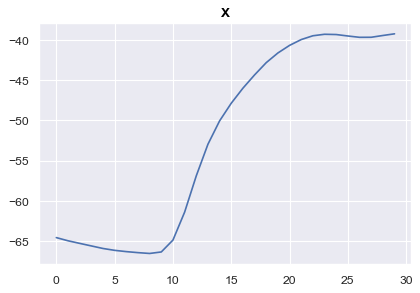

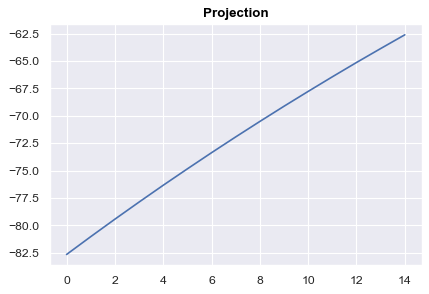

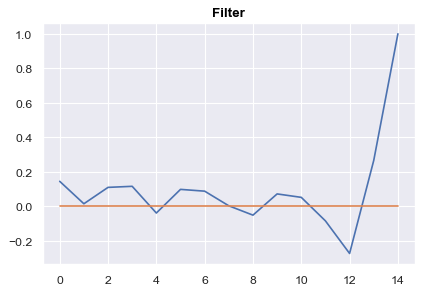

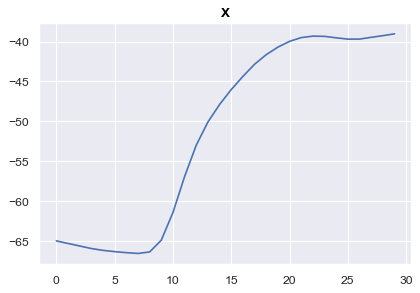

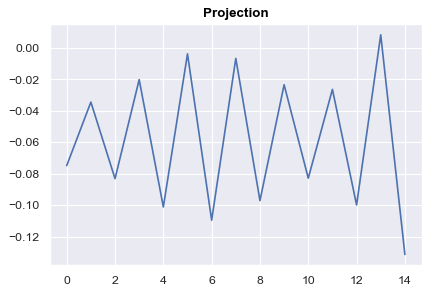

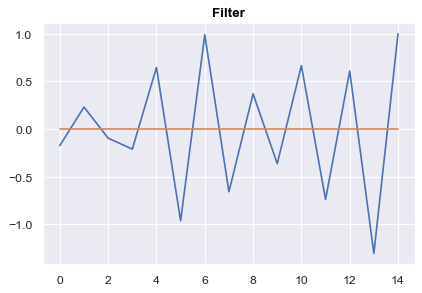

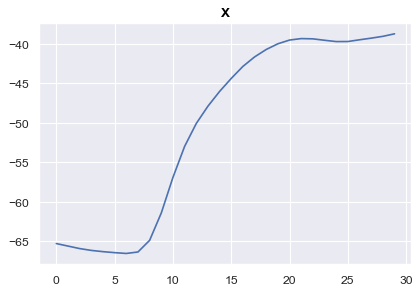

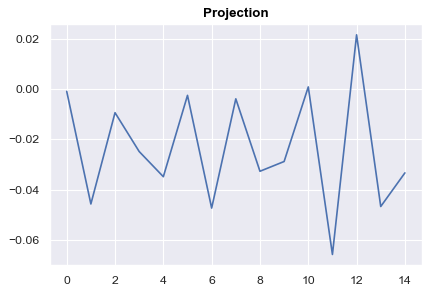

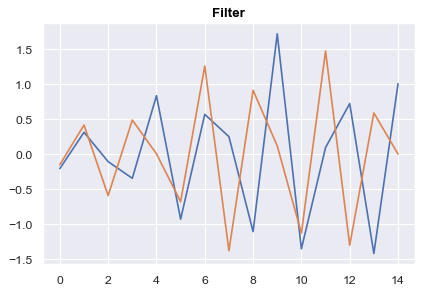

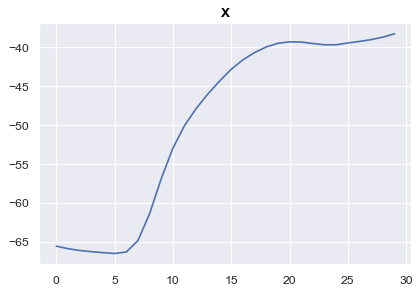

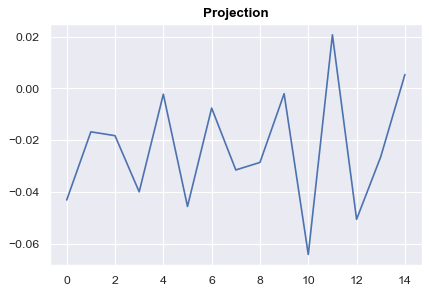

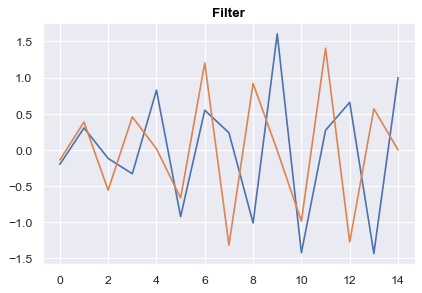

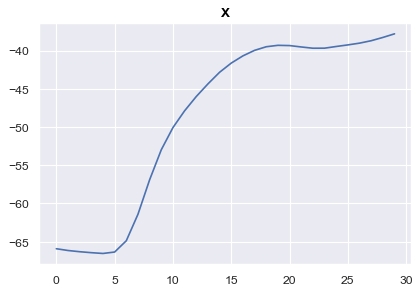

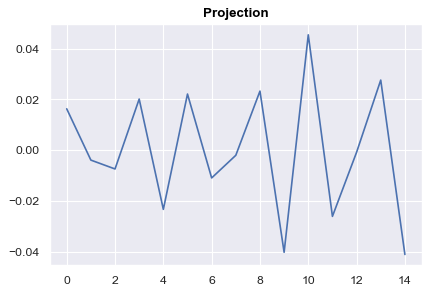

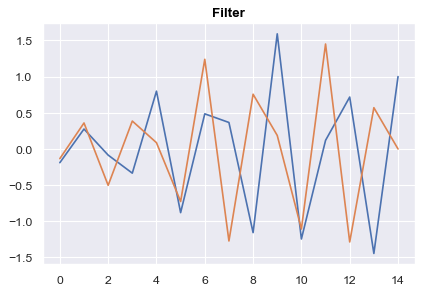

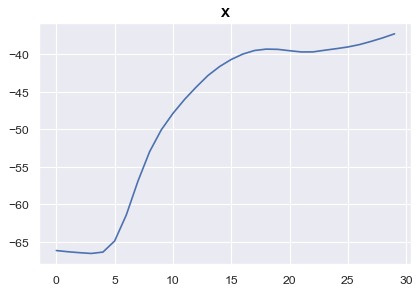

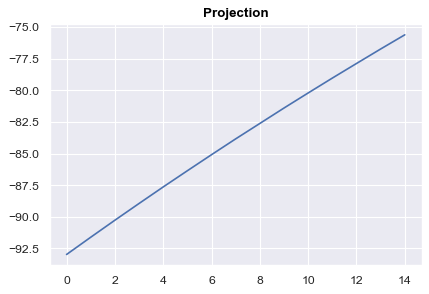

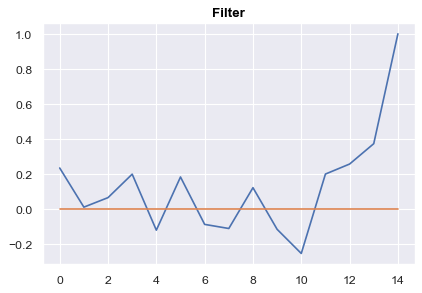

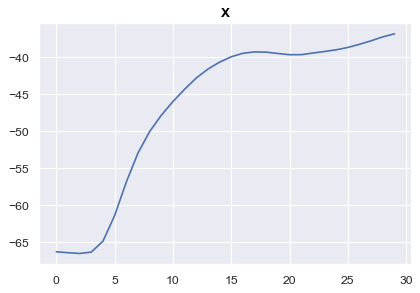

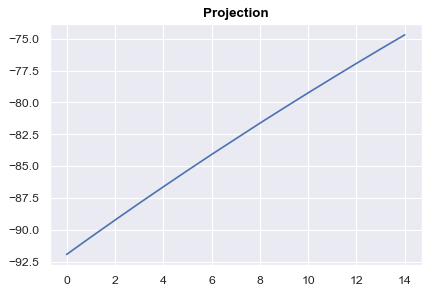

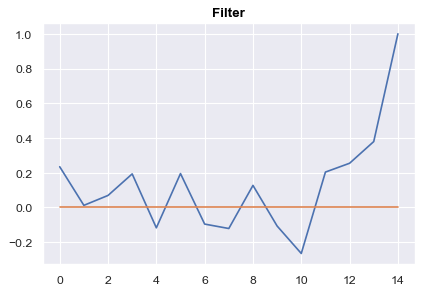

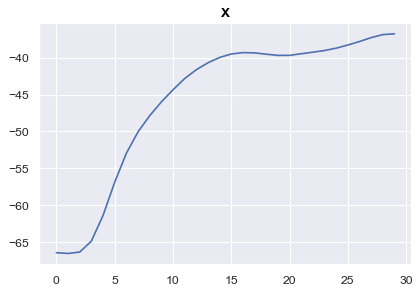

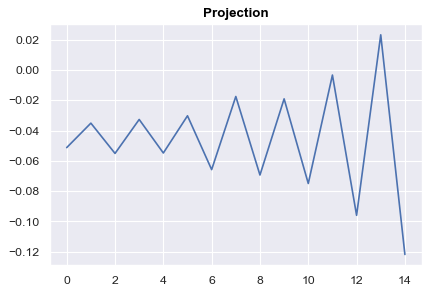

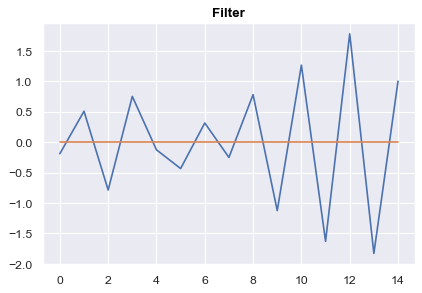

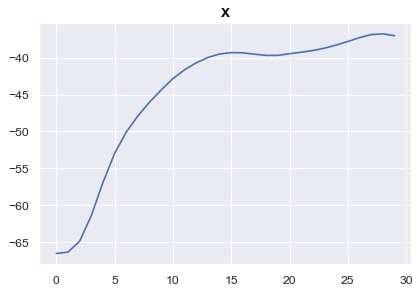

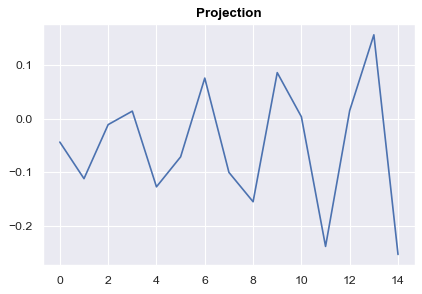

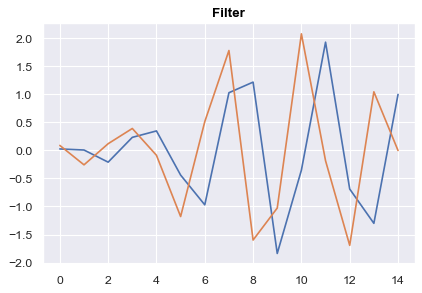

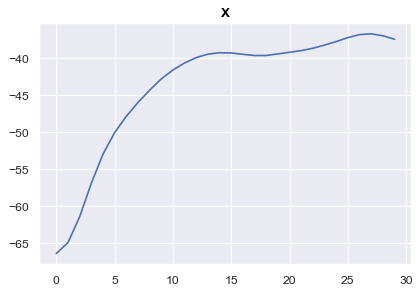

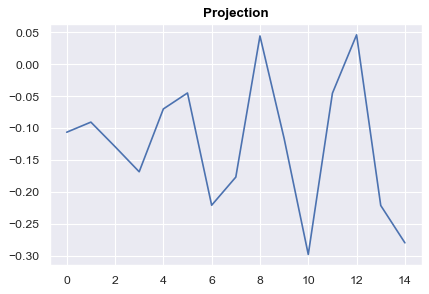

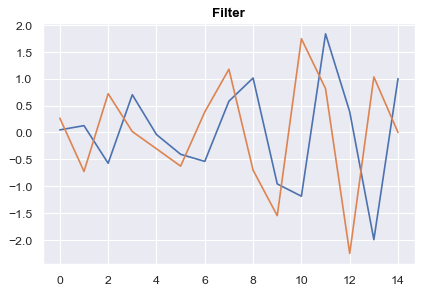

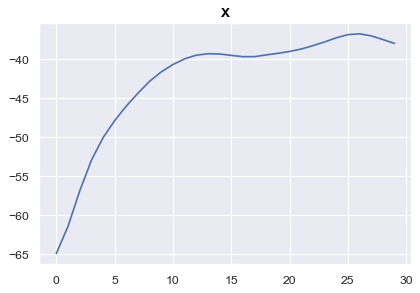

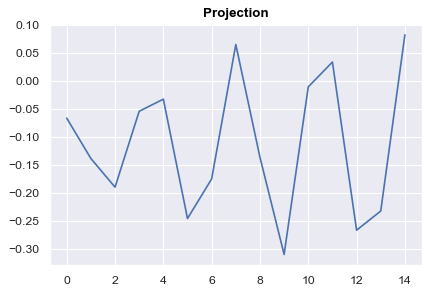

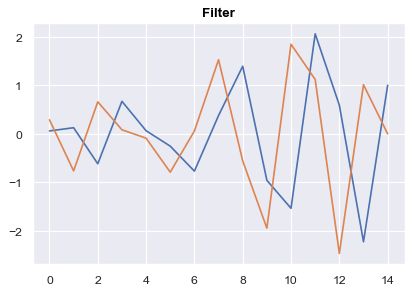

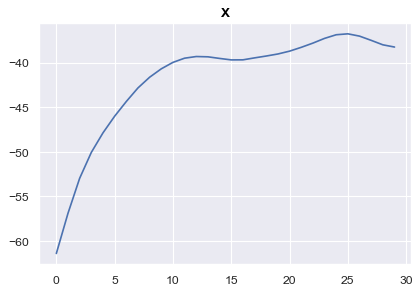

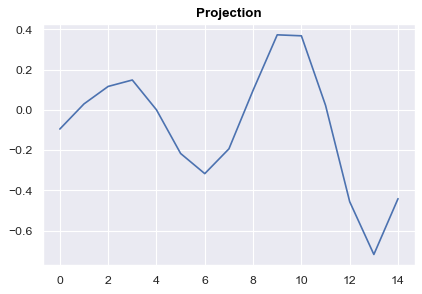

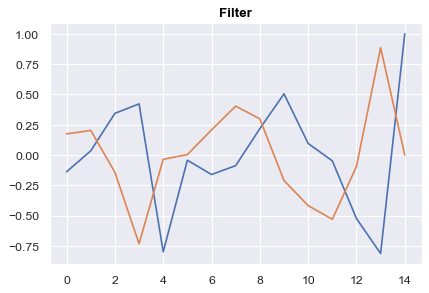

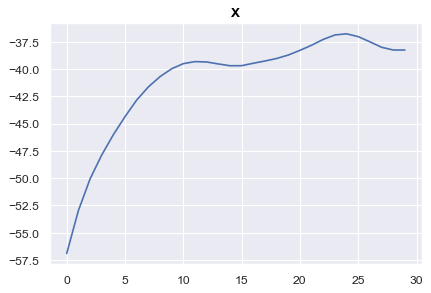

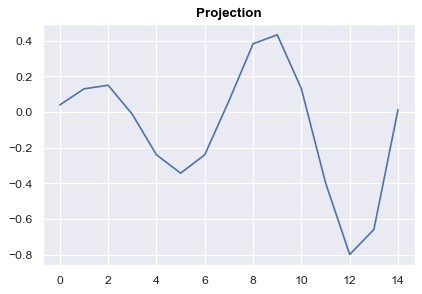

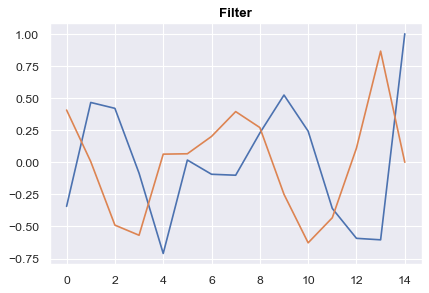

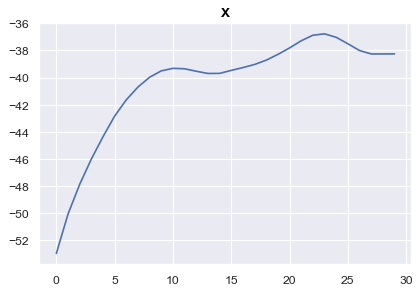

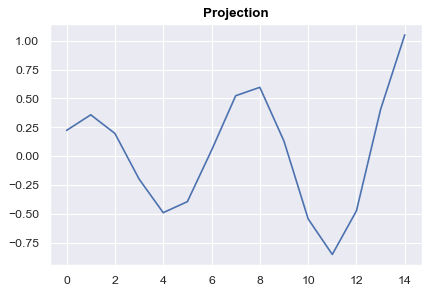

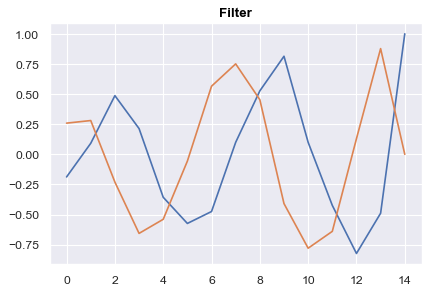

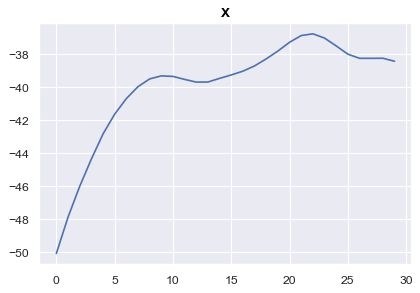

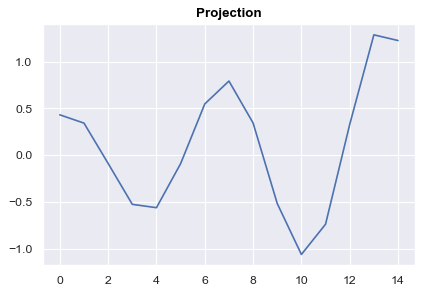

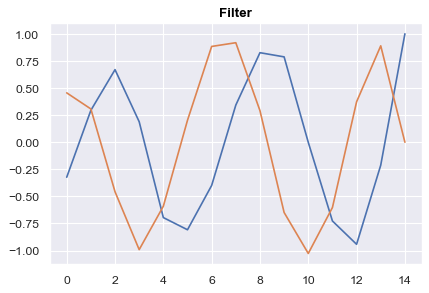

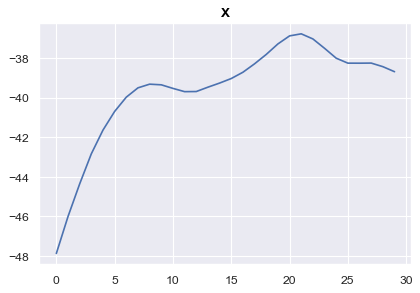

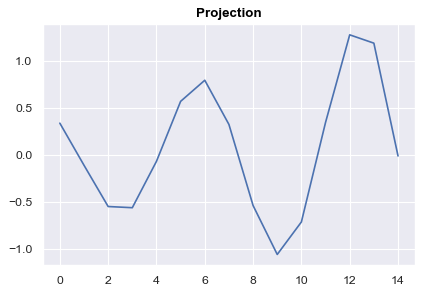

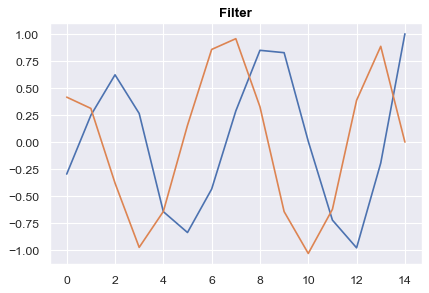

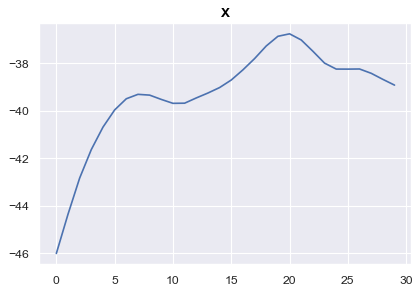

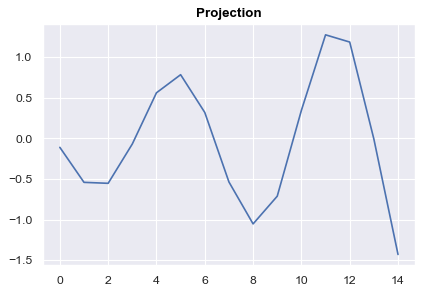

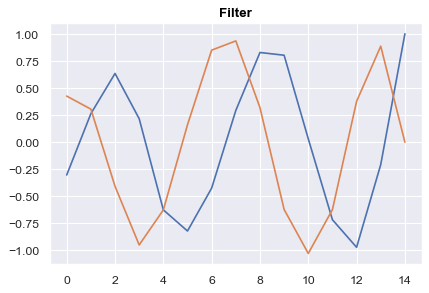

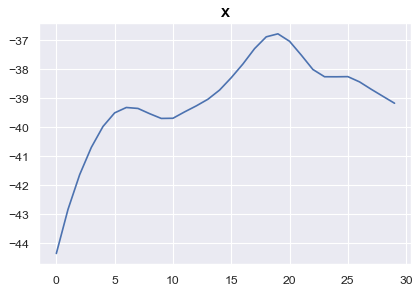

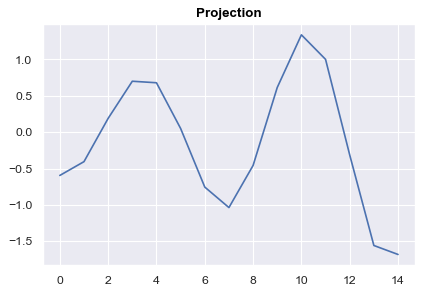

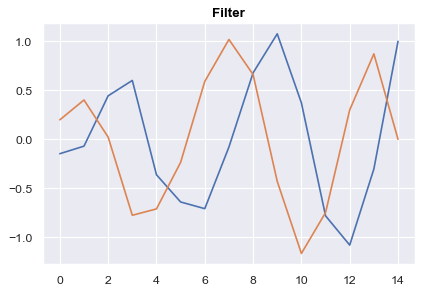

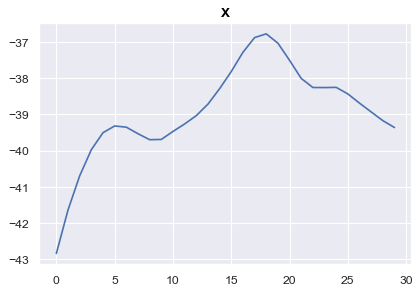

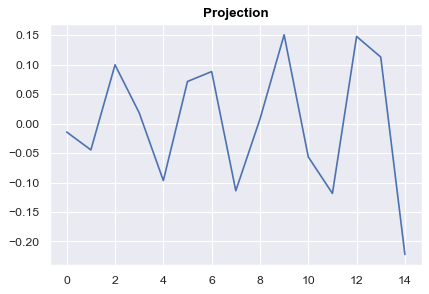

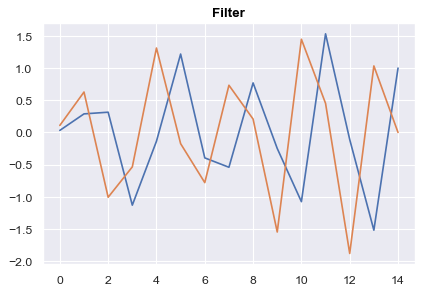

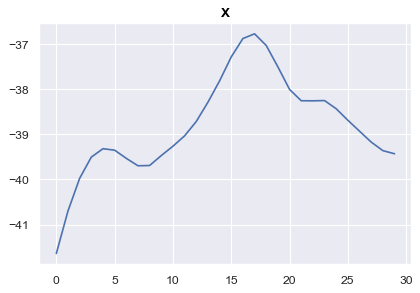

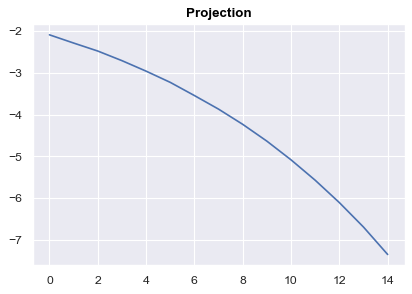

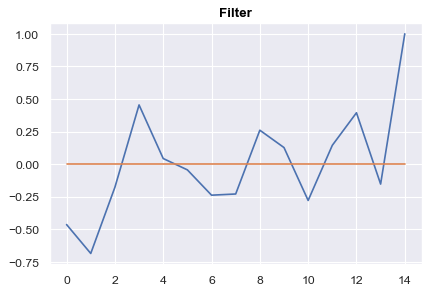

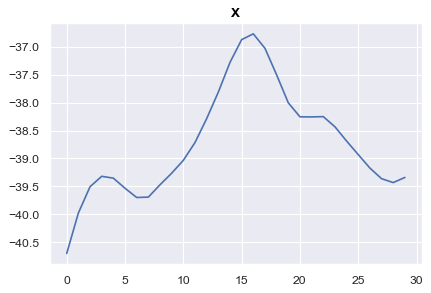

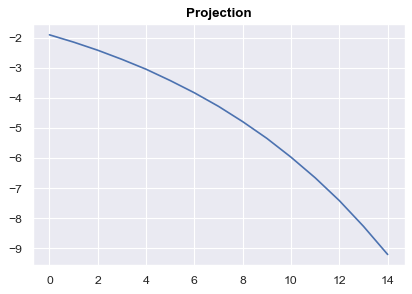

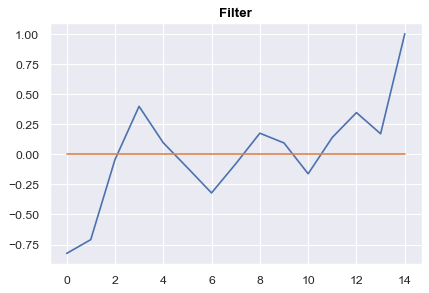

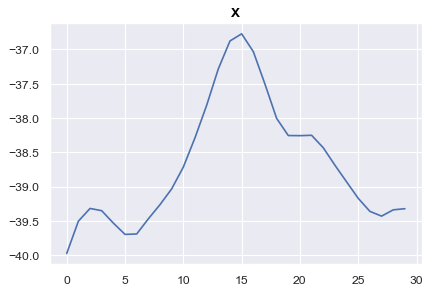

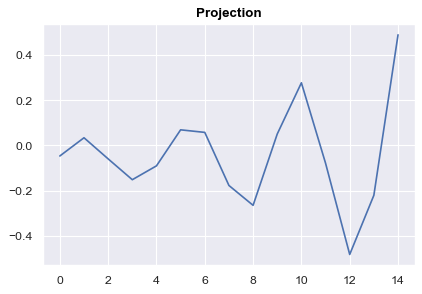

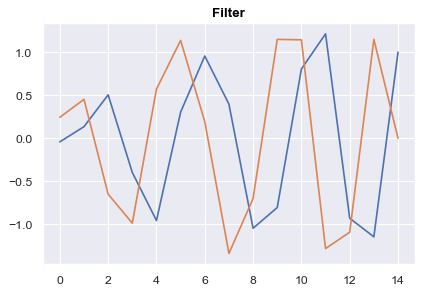

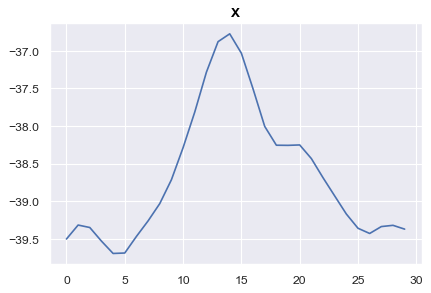

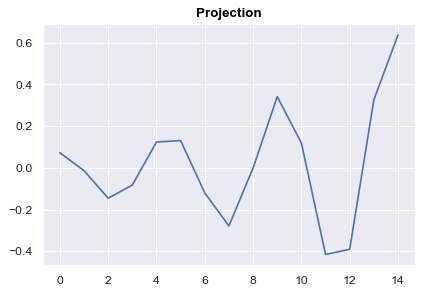

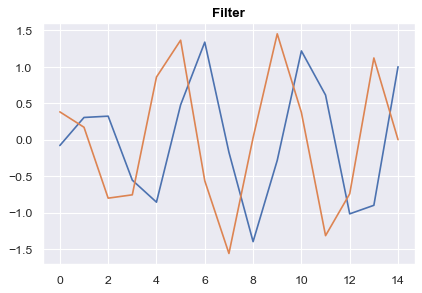

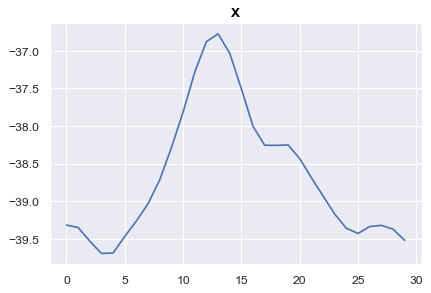

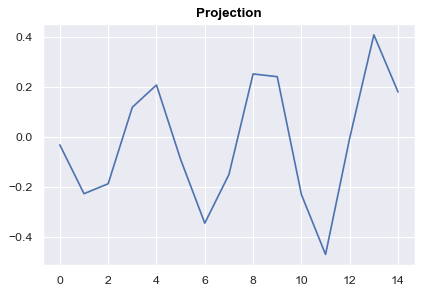

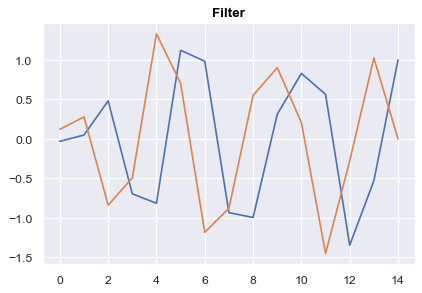

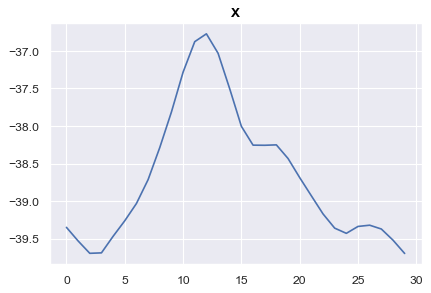

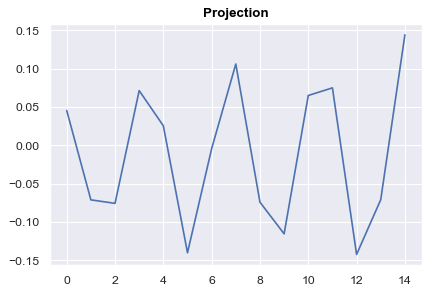

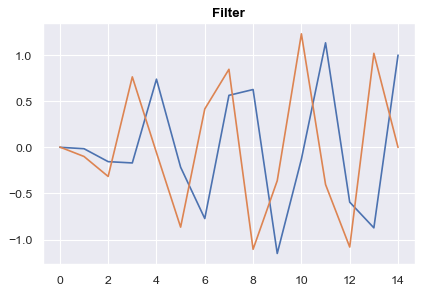

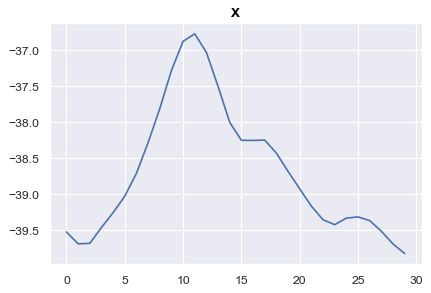

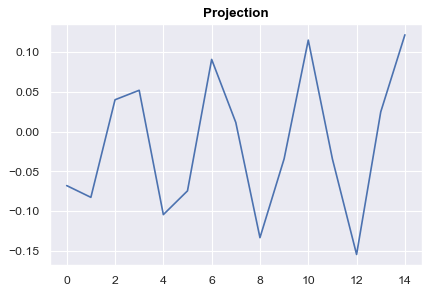

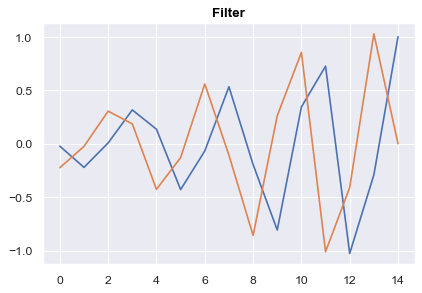

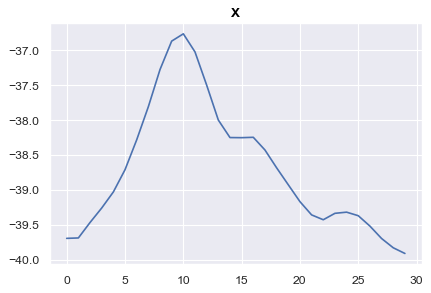

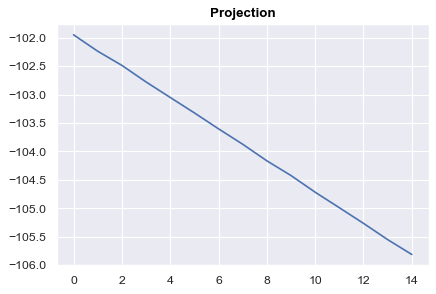

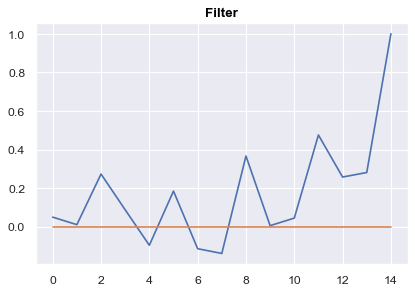

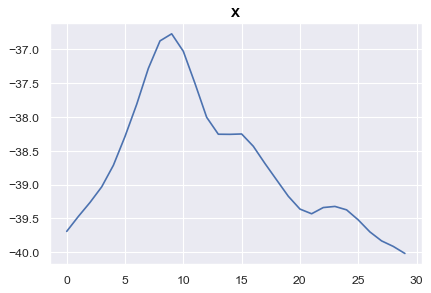

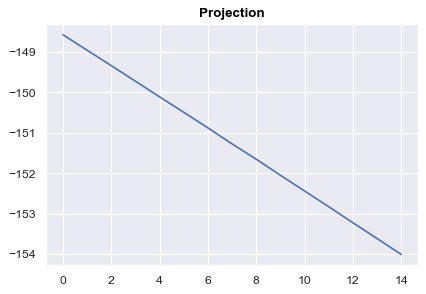

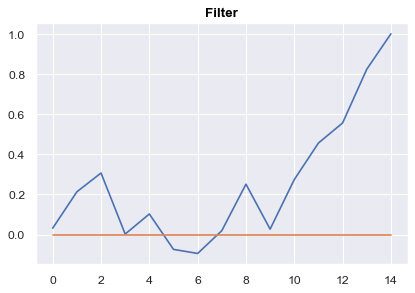

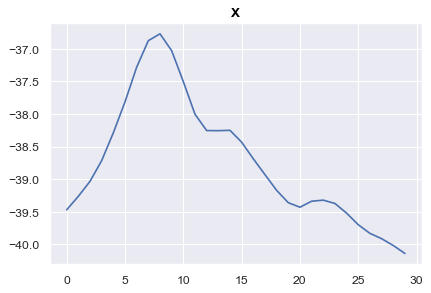

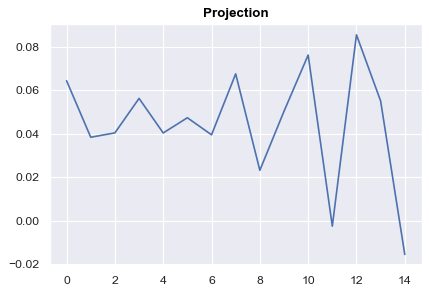

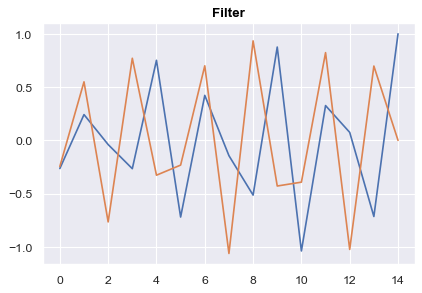

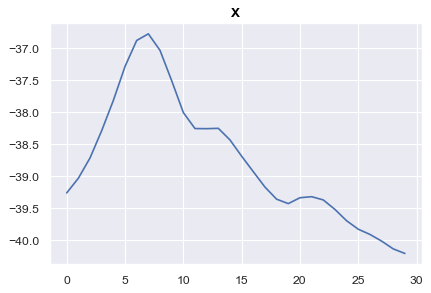

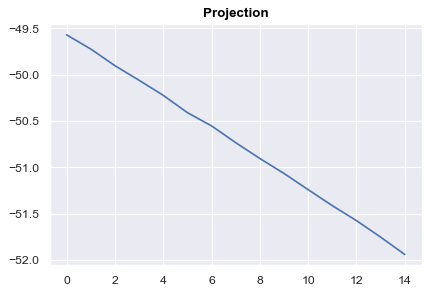

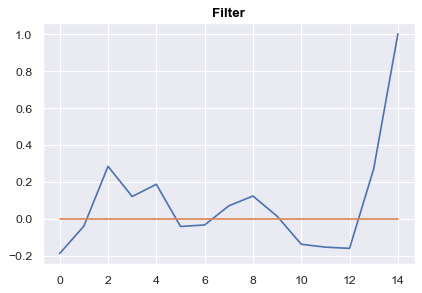

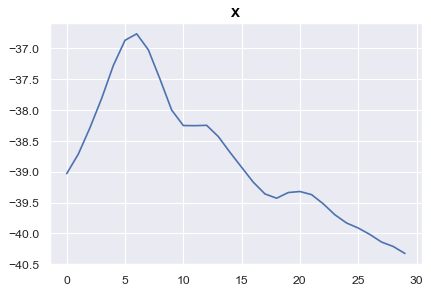

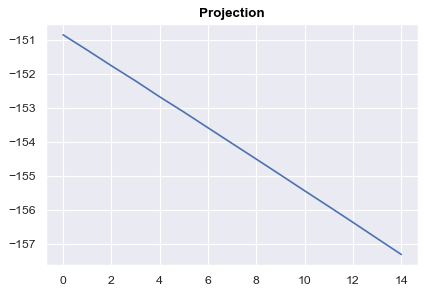

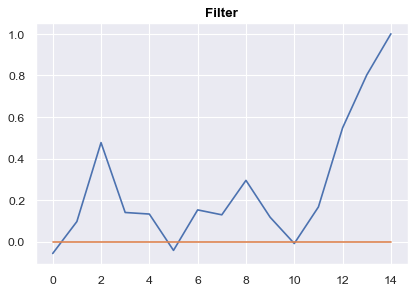

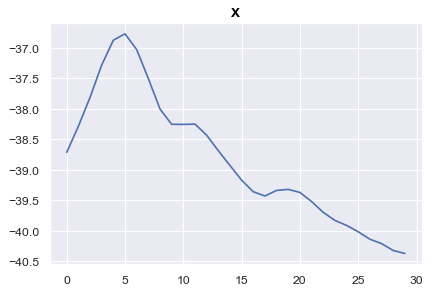

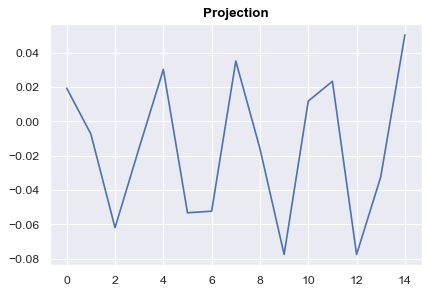

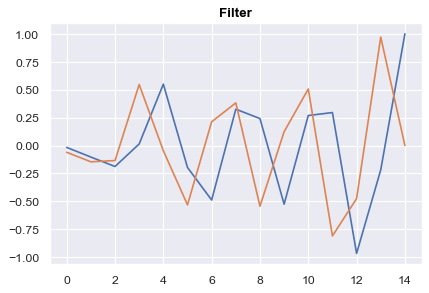

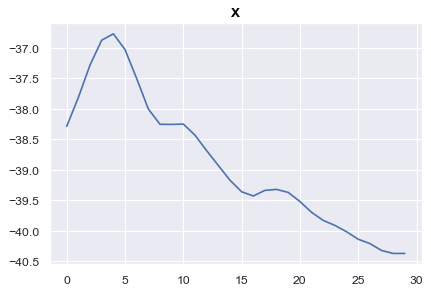

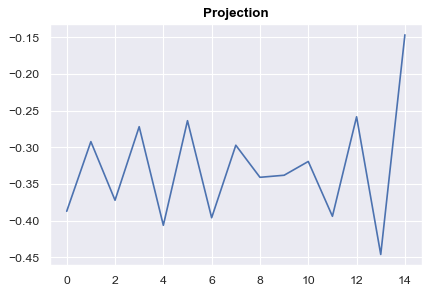

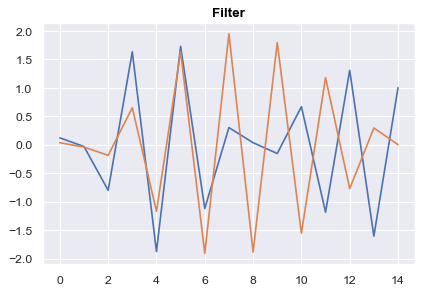

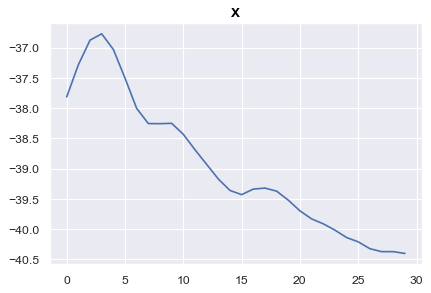

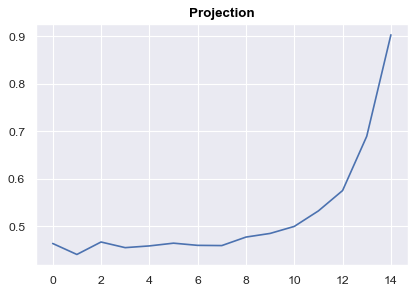

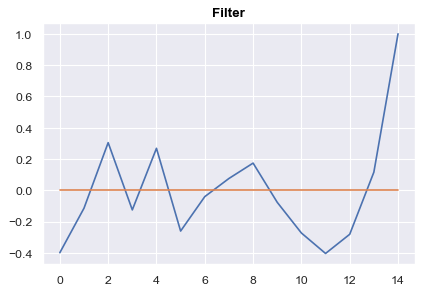

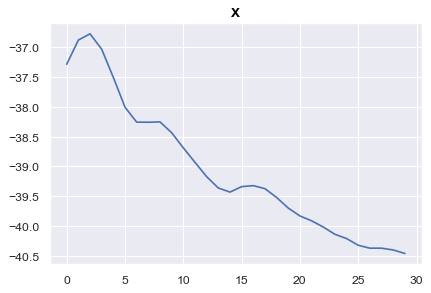

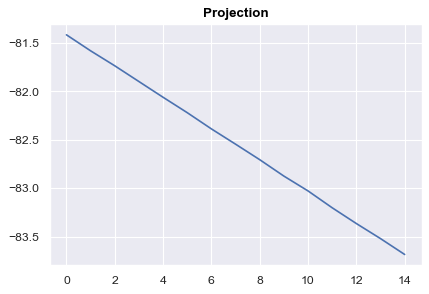

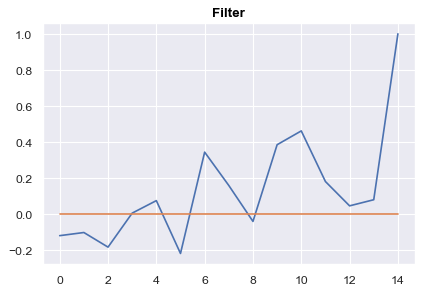

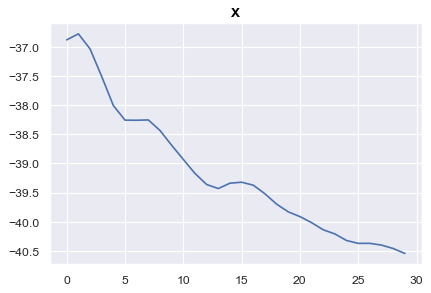

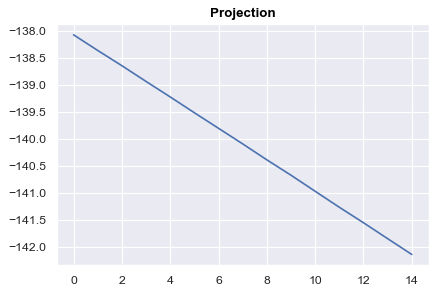

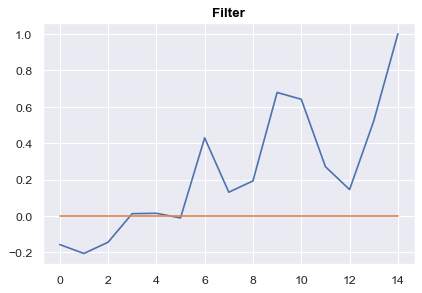

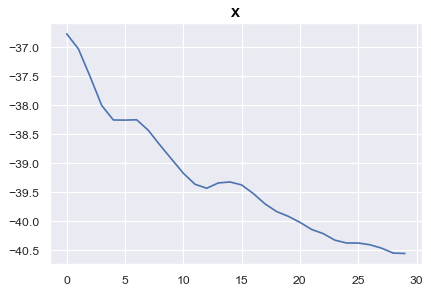

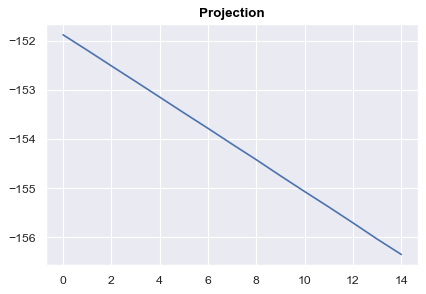

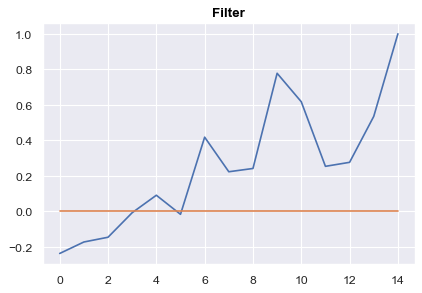

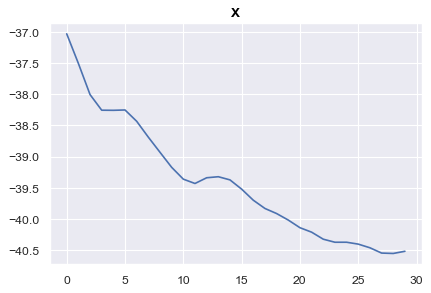

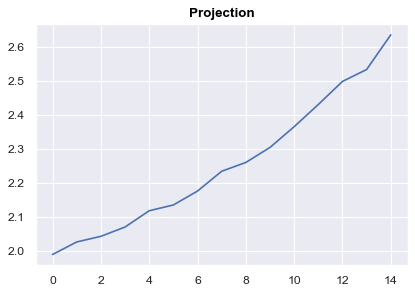

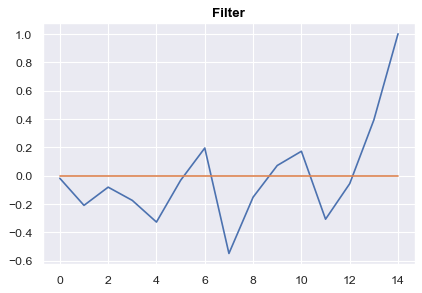

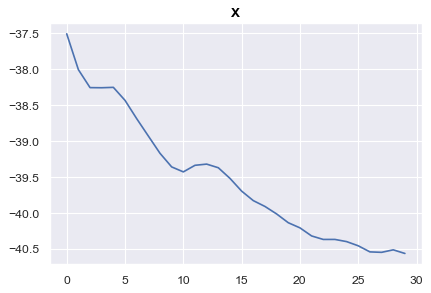

KeyboardInterrupt: 

<Figure size 480x320 with 0 Axes>

In [3]:
dt_ms = 2.0
lag_ms = 30
window_factor = 2
beta = 1e-3
factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, lag_ms)
X_series, Y_series = get_data('PHOTO', factor)

time = np.linspace(0, 1, len(X_series))
N = len(X_series)
window = int(dim * window_factor)
print(window)
thetas = []
Xhan = build_hankel(X_series, dim)
P_series = np.zeros(N)
for i in range(window, N, 1):
    P_series_w, theta, A, c = eig_companion_Cshift(X_series[i-window:i], dim, beta=beta)
    thetas.append(theta)
    plt.plot(X_series[i-window:i]); plt.title('X')
    plt.show()
    plt.plot(P_series_w); plt.title('Projection')
    plt.show()
    plt.plot(theta.real); plt.title('Filter')
    plt.plot(theta.imag); 
    plt.show()
    P_series[i-window:i-window+len(P_series_w)] = P_series_w
        
theta = np.mean(thetas, axis=0)


In [ ]:
P_series.shape
Y_series.shape

In [ ]:
Y_series = Y_series[dim:]
P_series = P_series[:-dim]
P_series = solve_scale_shift(P_series, Y_series)

err = mean_square_error(Y_series, P_series)
print(err)

In [ ]:
plt.plot(P_series)
plt.plot(Y_series)